# [GD10]CAM_Class_Activation_map

 - 모델과 추론의 신뢰성에 대한 답을 찾는 XAI(Explainable Artificial Intelligence, 설명 가능한 인공지능) 분야
 - XAI 기법은 모델의 성능을 개선할 수 있는 단서
 
 - 최근 AI가 좋은 결과를 내고 있지만 심각한 문제가 발생한 경우 약간의 블랙박스로서 알 수가 없었다. 
 - 어떤 과정으로 도출 되었는지 설명이 가능하다면 사람들이 이해할 수 있는 방향으로 나온 것으로 미국방성에서 제일 먼저 관심 갖은 분야 
 
 - CAM 논문의 연구진은 CAM을 얻기 위해서 GAPP(global average pooling) 을 사용했으며, 이를 통해서 어떤 클래스가 어느 영역에 의해서 활성화되었는지 알 수 있도록 합니다.
 - Network in Network 논문에서는 CNN 이후 fully connected layer를 사용하는 대신 아래 그림처럼 GAP 연산을 한 후 이에 대해 소프트맥스 활성화 함수를 적용합니다. 이때 마지막 CNN 레이어의 채널 수는 데이터의 클래스 수에 맞춰 각 클래스에 따른 확률을 얻을 수 있도록 했습니다. 원 논문에서는 이렇게 하면 특성 맵의 각 채널이 클래스별 신뢰도를 나타내게 되어 해석이 쉬울 뿐만 아니라, fully connected layer과 달리 최적화할 파라미터가 존재하지 않으므로 과적합(overfitting)을 방지할 수 있다고 설명합니다.
 - CNN 레이어를 거친 특성 맵에도 입력값의 위치정보가 유지됩니다. 따라서 우리는 특성 맵의 정보를 이미지 검출(detection)나 세그멘테이션(Segmentation) 등의 문제를 푸는 데 이용하기도 합니다. 

## 실습목표
1. Classification model로부터 CAM을 얻어낼 수 있다.
2. CAM으로 물체의 위치를 찾을 수 있다.
3. CAM을 시각화 비교할 수 있다.

 - CAM(Class Activation Map)은 특성을 추출하는 CNN 네트워크 뒤에 GAP(Global Average Pooling)와 소프트맥스 레이어(softmax layer)가 붙는 형태로 
   구성되어야 한다는 제약이 있습니다.
 - 반면에 Grad-CAM은 이러한 제약이 없죠.
 - CAM은 클래스에 대한 활성화 정도를 나타낸 지도입니다. 따라서 기본적으로 우리의 모델은 분류(classfication)를 수행하는 모델이어야 합니다. 
 - 우리의 최종 목표는 이미지 내에서 클래스가 활성화 된 위치를 확인하고 이를 정답과 비교하는 것이므로 위치 정보가 기록된 데이터가 함께 있어야 합니다.

## 세부내용
 - 노드의 CAM 구현
 - 노드의 GRAD-CAM 구현
 - 스스로 CAM / GRAD-CAM 구현해보기
 - 이전 노드에서 배운 Segmentation Unet, Unet++ 에 GRAD-CAM 적용해보기

In [6]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [11]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

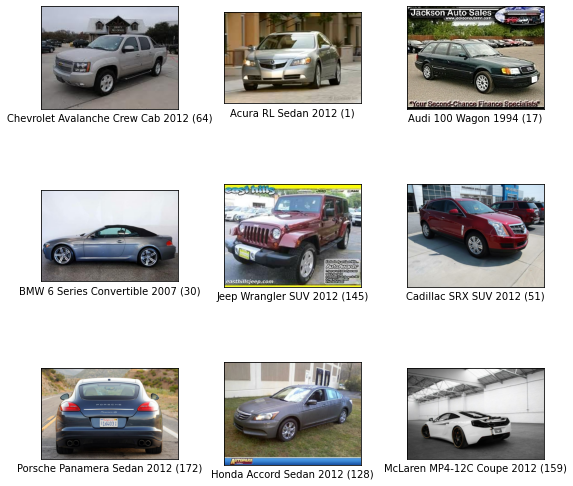

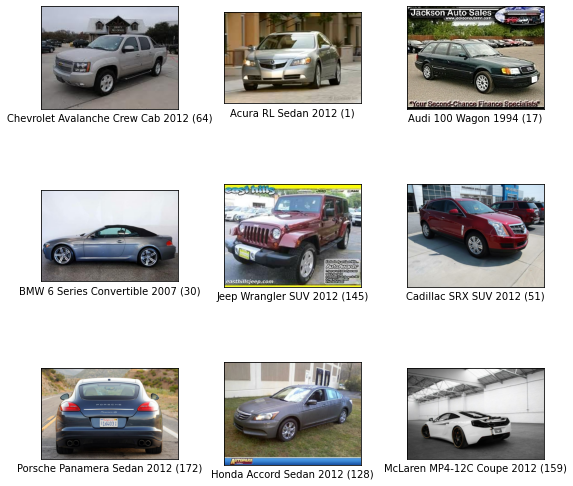

In [4]:
tfds.show_examples(ds_train, ds_info)

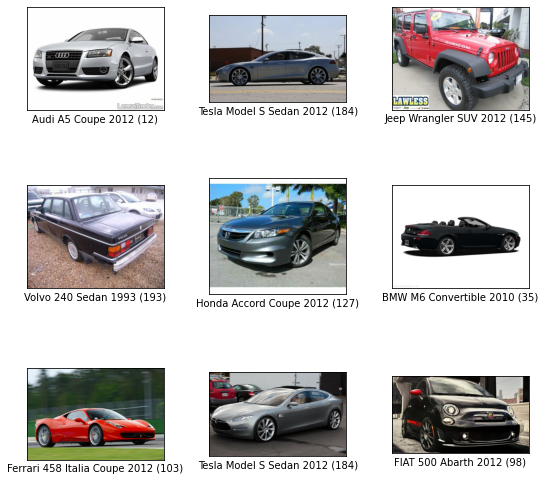

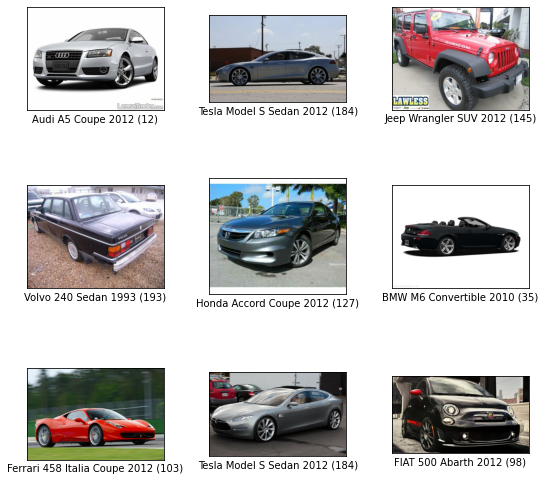

In [5]:
tfds.show_examples(ds_test, ds_info)

In [6]:
ds_info.features

FeaturesDict({
    'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=196),
})

'xywh' 는 바운딩박스 중심점을 x, y로 표기하고, 사각형의 너비 w와 높이 h를 표기하는 방법 (x_center, y_center, width, height)
'minmax'는 바운딩박스를 이루는 좌표의 최소값과 최대값을 통해 표기하는 방법 (x_min, x_max, y_min, y_max)

## CAM 을 위한 모델 만들기
 - 이미지넷(imagenet) 데이터에 훈련된 resnet50을 기반으로 활용하고, 이후 pooling layer 뒤에 소프트맥스 레이어를 붙여 Grad-CAM 모델을 만들겠습니다.

In [9]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet.ResNet50(
    include_top=False,     # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224,3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation = 'softmax')(x)
cam_model=keras.Model(inputs=base_model.input, outputs=preds)


In [10]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

 - conv5_block3_out의 output이 feature map이 됩니다. 따라서 이 feature map에 Global average pooling을 하여 feature의 크기를 줄이고, 줄어든 feature 전체에 Dense layer를 붙여 classification을 수행하게 됩니다.

## CAM 모델 학습하기
 - 학습 데이터와 검증 데이터에 normalizing과 resizing을 포함한 간단한 전처리를 normalize_and_resize_img() 에서 수행하며, 이를 포함하여 apply_normalize_on_dataset()에서 배치를 구성
 - input에 이전과 다르게 bbox 정보가 포함되어있지만, 지금 수행해야 할 CAM 모델의 학습에는 필요가 없으므로 normalize_and_resize_img과정에서 제외해 주었습니다. CAM 모델은 object detection이나 segmentation에도 활용될 수 있지만, bounding box같은 직접적인 라벨을 사용하지 않고 weakly supervised learning을 통해 물체 영역을 간접적으로 학습시키는 방식이기 때문입니다.

In [14]:
def normalize_and_resize_img(input):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [12]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [13]:
tf.random.set_seed(2021)
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)


In [14]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=15,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
509/509 [==============================] - 113s 169ms/step - loss: 4.8728 - accuracy: 0.0727 - val_loss: 5.4594 - val_accuracy: 0.0066
Epoch 2/15
509/509 [==============================] - 98s 193ms/step - loss: 2.0438 - accuracy: 0.5500 - val_loss: 1.8615 - val_accuracy: 0.5183
Epoch 3/15
509/509 [==============================] - 86s 168ms/step - loss: 0.7469 - accuracy: 0.8579 - val_loss: 1.2838 - val_accuracy: 0.6597
Epoch 4/15
509/509 [==============================] - 86s 169ms/step - loss: 0.2192 - accuracy: 0.9721 - val_loss: 1.0924 - val_accuracy: 0.7131
Epoch 5/15
509/509 [==============================] - 86s 169ms/step - loss: 0.0796 - accuracy: 0.9964 - val_loss: 1.0321 - val_accuracy: 0.7311
Epoch 6/15
509/509 [==============================] - 86s 169ms/step - loss: 0.0483 - accuracy: 0.9973 - val_loss: 1.0018 - val_accuracy: 0.7351
Epoch 7/15
509/509 [==============================] - 86s 169ms/step - loss: 0.0233 - accuracy: 0.9985 - val_loss: 0.9980 - val_a

In [15]:
import os

cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model.save(cam_model_path)
print("저장 완료!")

저장 완료!


## CAM
 - 이제 학습된 모델에서 CAM을 생성해 봅시다. CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에, get_one() 함수로 데이터셋에서 한 장씩 뽑을 수 있도록 했습니다.

In [16]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

121


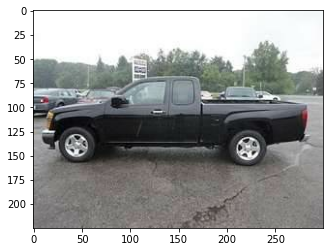

In [17]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

In [18]:
# CAM을 생성하기 위해 이전 스텝에서 학습한 모델을 불러와 봅시다.
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

 - CAM을 생성하기 위해서는 (1) 특성 맵, (2) 클래스 별 확률을 얻기 위한 소프트맥스 레이어의 가중치, 그리고 (3) 원하는 클래스의 출력값이 필요합니다. 또 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화 해야 할 것입니다. 이를 고려해서 model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야 합니다.
 - generate_cam() 을 구현하기 위해 아래에서는 conv_ouputs와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의하고, feedforward를 거친 후 CAM을 계산하도록 구현하였습니다. 마지막에는 입력 이미지의 크기에 맞춰 CAM을 resize 해주었습니다.

In [19]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

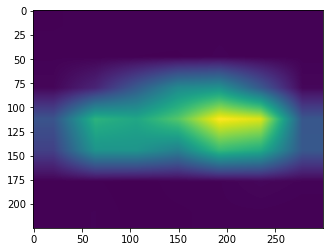

In [20]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

In [21]:
# 원본 이미지와 합치기
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

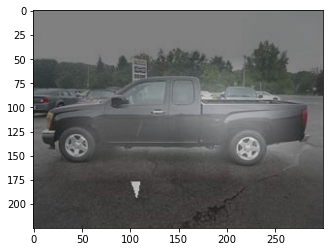

In [22]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

## Grad-CAM
 - Grad-CAM을 이용해서 CAM을 얻어보도록 하겠습니다. 적용 모델을 유연하게 선택할 수 있는 Grad-CAM의 특성 상 위에서 만들었던 모델을 다시 활용해도 괜찮기 때문에 관찰 대상 모델은 cam_model을 그대로 활용합시다.

141


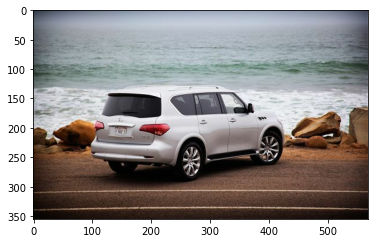

In [23]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

grad_cam은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 그래디언트를 구하고, 여기에 GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구합니다. 최종 CAM 이미지를 구하기 위해서는 레이어의 채널별 가중치(weights)와 레이어에서 나온 채널별 특성 맵을 가중합 해주어 cam_image를 얻게 됩니다.

위에서 본 CAM 함수와 달리, Grad-CAM은 이번에는 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, 그래디언트 계산을 원하는 관찰 대상 레이어 activation_layer를 뽑아서 쓸 수 있도록 activation_layer의 이름을 받고 이를 활용해야 합니다.

아래 generate_grad_cam()에서는 원하는 레이어의 output과 특정 클래스의 prediction 사이의 그래디언트 grad_val을 얻고 이를 weights로 활용합니다.

In [24]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

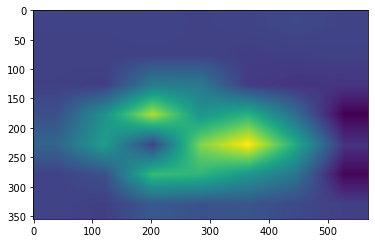

In [25]:
# 이제 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해보세요! 레이어의 이름은 cam_model.summary()에서 찾을 수 있습니다.
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

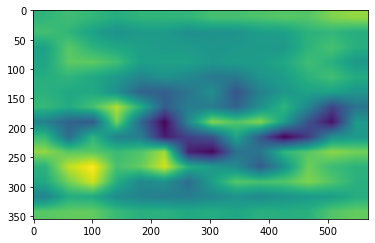

In [26]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)

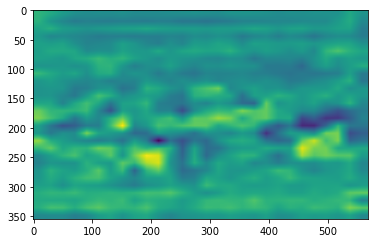

In [27]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)

## Detection with CAM
 - CAM에서 물체의 위치를 찾는 detection

130


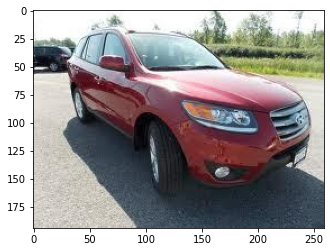

In [28]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

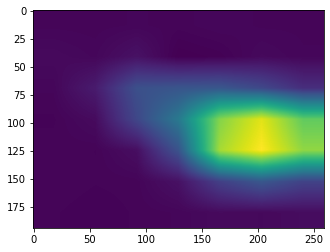

In [29]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

이전의 generate_cam을 활용해서 CAM 이미지를 뽑아봅시다. 아래 get_bbox() 함수는 바운딩 박스를 만들기 위해서 score_thresh를 받아 역치값 이하의 바운딩 박스는 없앱니다. 그 다음 OpenCV의 findContours()와 minAreaRect()로 사각형을 찾습니다. 이때 rotated_rect 라는 회전된 바운딩 박스를 얻을 수 있습니다. boxPoints()로 이를 꼭지점으로 바꾸어 줍니다. 마지막에는 int 자료형으로 변환해 줍니다.

In [30]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect


In [31]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect

array([[ 47, 169],
       [ 51,  42],
       [262,  49],
       [257, 176]])

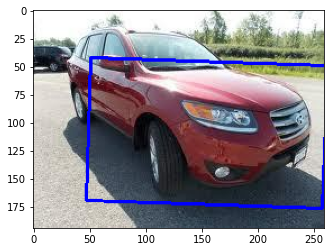

In [32]:
image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

Intersection Over Union
위에서 CAM과 Grad-CAM 두 가지 방법을 통해서 얻은 바운딩 박스가 있습니다. 그럼 정답 데이터인 바운딩 박스와 이를 비교 평가 할 때는 어떻게 할 수 있을까요?
IoU(Intersection over Union)는 두 개 영역의 합집합인 "union" 영역으로 교집합 영역인 "intersection" 영역의 넓이를 나누어준 값입니다. 이를 통해 찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지 상대적인 비율을 구할 수 있으므로 모델이 영역을 잘 찾았는지 비교하는 좋은 지표가 됩니다.



In [33]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

In [34]:
# rect를 minmax bbox 형태로 치환해 봅시다.
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox


[0.21649484536082475,
 0.18146718146718147,
 0.9072164948453608,
 1.0115830115830116]

In [35]:
# ground truth bbox
item['bbox']

array([0.08762886, 0.11969112, 0.8556701 , 0.98841697], dtype=float32)

In [36]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [37]:
get_iou(pred_bbox, item['bbox'])

0.7116065700830955

# 프로젝트 CAM을 만들고 평가해 보자


In [35]:
import os
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)

In [36]:
#  CAM을 직접 구현
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

13


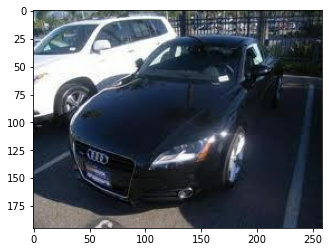

In [37]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])

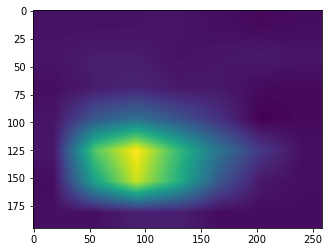

In [38]:
# 만든 함수로 CAM 이미지를 생성합시다.
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)

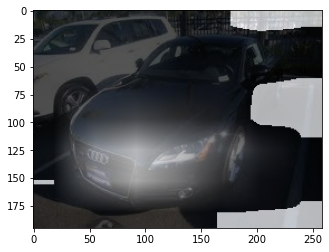

In [39]:
# 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 visualize_cam_on_image() 함수
def visualize_cam_on_image(src1, src2, alpha=0.7):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

# visualize_cam_on_image() 함수 사용
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)



In [40]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect


In [41]:
image = copy.deepcopy(item['image'])
rect = get_bbox(cam_image)
rect

array([[ 20,  51],
       [226,  51],
       [226, 180],
       [ 20, 180]])

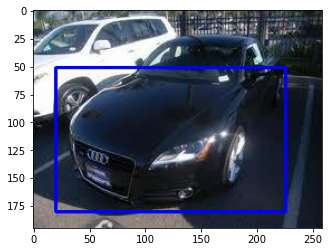

In [42]:
image = cv2.drawContours(image,[rect],0,(0,0,255),2)
plt.imshow(image)

In [43]:
# Grad-CAM 구현하기
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

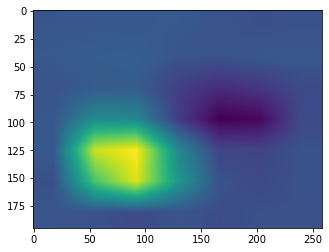

In [44]:
# CAM 이미지를 뽑아서 직접 확인
# 이제 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해보세요! 레이어의 이름은 cam_model.summary()에서 찾을 수 있습니다.
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)

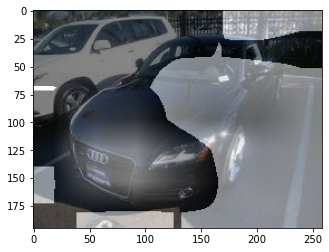

In [45]:
# visualize_cam_on_image() 함수로 이미지를 시각화
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

# visualize_cam_on_image() 함수 사용
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)

In [51]:
def get_bbox_grad(grad_cam_image, score_thresh=0.05):
    low_indicies = grad_cam_image <= score_thresh
    grad_cam_image[low_indicies] = 0
    grad_cam_image = (grad_cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(grad_cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect


In [52]:
image = copy.deepcopy(item['image'])
rect_grad = get_bbox_grad(grad_cam_image)
rect_grad

array([[ 20,  71],
       [160,  71],
       [160, 177],
       [ 20, 177]])

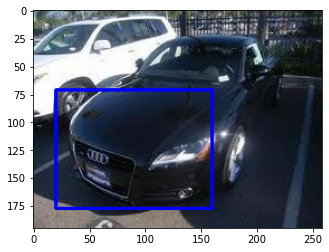

In [53]:
image = cv2.drawContours(image,[rect_grad],0,(0,0,255),2)
plt.imshow(image)

In [56]:
# IoU 구하기
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

# rect를 minmax bbox 형태로 치환해 봅시다.
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.3641025641025641,
 0.07722007722007722,
 0.9076923076923077,
 0.6177606177606177]

In [58]:
def rect_to_minmax_grad(rect_grad, image):
    bbox = [
        rect_grad[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect_grad[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect_grad[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect_grad[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

pred_bbox_grad = rect_to_minmax_grad(rect_grad, item['image'])
pred_bbox_grad

[0.3641025641025641,
 0.07722007722007722,
 0.9076923076923077,
 0.6177606177606177]

In [31]:
# 정답 바운딩 박스(ground truth)와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 get_iou() 함수를 만들어 주세요
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [32]:
# 2) CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해 봅시다.
get_iou(pred_bbox, item['bbox'])  # CAM

0.8022946628062163

In [59]:
get_iou(pred_bbox_grad, item['bbox']) # Grad-CAM

0.41832694915092367

# Segmentation U-Net

In [68]:
from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

In [69]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'
unet_model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training/seg_model_unet.h5'
model_unet = tf.keras.models.load_model(unet_model_path)

In [70]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [71]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

test_preproc = build_augmentation(is_train=False)

# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )


In [73]:
model_unet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 224, 224, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_30[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 112, 112, 64) 0           conv2d_31[0][0]                  
____________________________________________________________________________________________

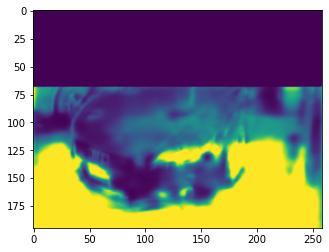

In [74]:
grad_cam_image = generate_grad_cam(model_unet, 'conv2d_53', item)
plt.imshow(grad_cam_image)

In [75]:
nested_unet_model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training/seg_model_nested_unet.h5'
model_nested_unet = tf.keras.models.load_model(nested_unet_model_path)
model_nested_unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 224, 224, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 112, 112, 64) 0           conv2d_21[0][0]                  
____________________________________________________________________________________________

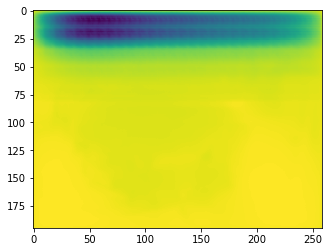

In [76]:
grad_cam_image_nested_unet = generate_grad_cam(model_nested_unet, 'conv15_2', item)
plt.imshow(grad_cam_image_nested_unet)

# 루브릭
1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?
 - ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.
2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?
 - CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.
3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?
 - CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.

# 결론
 - 아직 GRAD-CAM에 대한 이해가 부족하다. 노드의 설명이 부족해보이긴 하나 논문이나 다른 블로그 자료를 통해 찾아봐야겠다. 
 - Segmentation이나 다른 어떤 모델을 불러오더라도 GRAD-CAM을 적용해서 결과를 보일 수 있어 꽤 유용한것같다.
 - 각 레이어별로 특징이 어떻게 나타나는지 쉽게 이해될 수 있을것같다.
 - XAI ! SAI ! SAiffel 에도 적용해보자